In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
from scipy.ndimage import zoom, rotate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import glob

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence
import keras.backend as K

import tensorflow as tf

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [7]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#config.allow_soft_placement = True
#set_session(tf.Session(config=config))

In [8]:
df = pd.read_csv("/content/drive/MyDrive/LIDC/final_data.csv")

In [9]:
agg_func = {'calcification': 'mean', 'internalStructure': 'mean', 'lobulation': 'mean', 'malignancy': 'mean',
            'margin': 'mean', 'path': 'first', 'sphericity': 'mean', 'spiculation': 'mean', 'subtlety': 'mean', 'texture': 'mean',
            'xf': 'first', 'xi': 'first', 'yf': 'first', 'yi': 'first', 'zf': 'first', 'zi': 'first'}

In [10]:
df = df.groupby("final_id").agg(agg_func)

In [11]:
df[['calcification', 'internalStructure', 'lobulation', 'malignancy', 'margin', 'sphericity', 'spiculation', 'subtlety', 'texture']] = df[['calcification', 'internalStructure', 'lobulation', 'malignancy', 'margin', 'sphericity', 'spiculation', 'subtlety', 'texture']]/df[['calcification', 'internalStructure', 'lobulation', 'malignancy', 'margin', 'sphericity', 'spiculation', 'subtlety', 'texture']].max()

In [12]:
df = df[['path', 'calcification', 'internalStructure', 'lobulation', 'malignancy',
       'margin', 'sphericity', 'spiculation', 'subtlety', 'texture']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.index.tolist(), df, stratify=df.malignancy, test_size=0.2, random_state=22)

ids_train = X_train
ids_test = X_test

In [14]:
tags_train = (df.loc[ids_train].malignancy.values > 0.5).astype(np.int)

In [15]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(tags_train),
                                                 tags_train)

In [16]:
n_classes = 1
chanels = 1
batch_size = 70
vol_size = np.array([40, 40, 40])

path_base = '/content/drive/MyDrive/LIDC/nodules/{}.npz'

In [17]:
def normalize(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray = np.clip(npzarray, 0, 1)
    return npzarray

In [18]:
def get_data(nodule_id):
    tag = int(df.loc[nodule_id].malignancy > 0.5)
    
    file = np.load(path_base.format(nodule_id))
    vol = file['patch']
    file.close()
    
    vol = normalize(vol)
    vol = zoom(vol, vol_size/np.array(vol.shape), order=0)
    return vol, tag

In [27]:
#degrees = [0, 90, -90]
degrees = [0, 90, -90, 80, -80, 70, -70]
axis = [0, 1, 2]

In [28]:
def get_random_params():
    d = np.random.choice(degrees)
    a = np.random.choice(axis, size=2, replace=False)
    return d, a

In [31]:
class Sequence_data(Sequence):

    def __init__(self, data, batch_size, is_training):
        # recive una lista de rutas de donde están los volumenes como numpy arrays y el batch_size
        self.data = data
        self.batch_size = batch_size
        self.is_training = is_training

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        # lista de rutas para el batch actual
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = []
        y = []
        
        # se cargan los volumenes y las mascaras en sus respectivos arrays
        for path in batch_x:
            data, tag = get_data(path)
            d, a = get_random_params()
            if self.is_training:
                data = rotate(data, d, a, reshape=False)
            X.append(data)
            
            temp_y = [0, 0]
            temp_y[tag] = 1
            
            y.append(temp_y)
            
        X = np.array(X)
        y = np.array(y)
        
        try:
            resahped = X.reshape((*X.shape, chanels)), y#.reshape(-1, n_classes)
        except Exception as ex:
            print('ojooooooo')
            print(batch_x, ex)
        return resahped

In [34]:
seq_train = Sequence_data(ids_train, batch_size, True)
seq_test = Sequence_data(ids_test, batch_size, False)

In [35]:
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from keras.layers import MaxPool3D, Conv3D, Input

In [36]:
def get_model(size = (128, 128, 64)):
    
    width, height, depth = size

    inputs = Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    #x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    #x = MaxPool3D(pool_size=2)(x)
    #x = BatchNormalization()(x)
    
    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling3D()(x)
    x = Dense(units=200, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(units=100, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(units=50, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=2, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3dcnn")
    return model

In [64]:
model = get_model(vol_size)

In [65]:
model.save('/content/cancer_model.hdf5')

In [70]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [40]:
#!mkdir /content/weights_cancer

In [67]:
ES = EarlyStopping(patience=20, min_delta=0.00001, restore_best_weights=True)
MCP = ModelCheckpoint(filepath="./weights_cancer/weights.{epoch:02d}.hdf5", save_best_only=False, save_weights_only=True)
callbacks = [ES, MCP]

In [68]:
weight = {i : class_weights[i] for i in range(2)}

In [1]:
history = model.fit(seq_train, validation_data=seq_test, class_weight=weight , steps_per_epoch=int(len(ids_train)/batch_size), epochs=200, callbacks=callbacks)

NameError: ignored

In [ ]:
pred = model.predict_generator(seq_test)

In [ ]:
tags = (df.loc[ids_test].malignancy.values > 0.5).astype(np.int)

In [ ]:
print(classification_report(tags, (pred.argmax(-1) > 0.5).astype(np.int).flatten()))

             precision    recall  f1-score   support

          0       0.83      0.39      0.53       227
          1       0.68      0.94      0.79       311

avg / total       0.74      0.71      0.68       538



In [ ]:
print(accuracy_score(tags, (pred.argmax(-1) > 0.5).astype(np.int).flatten()))

0.70817843866171


### Leonel Mera

In [43]:
ids_train[:10]

[1769.0, 2712.0, 846.0, 1877.0, 1099.0, 543.0, 1277.0, 65.0, 2548.0, 837.0]

In [44]:
X = []
y = []

# se cargan los volumenes y las mascaras en sus respectivos arrays
for path in ids_train[:10]:
    data, tag = get_data(path)
    d, a = get_random_params()
    if True:
        data = rotate(data, d, a, reshape=False)
    X.append(data)
    
    temp_y = [0, 0]
    temp_y[tag] = 1
    
    y.append(temp_y)
    
X = np.array(X)
y = np.array(y)

try:
    resahped = X.reshape((*X.shape, chanels)), y#.reshape(-1, n_classes)
except Exception as ex:
    print('ojooooooo')
    print(batch_x, ex)

In [50]:
print(np.shape(X))
print(np.shape(y))

(10, 40, 40, 40)
(10, 2)


In [56]:
list(class_weights)

[1.1906873614190687, 0.8619582664526485]

In [61]:
weight = {i : class_weights[i] for i in range(2)}
weight

{0: 1.1906873614190687, 1: 0.8619582664526485}

In [ ]:
model.fit(class_weight=)

In [ ]:
model.fit(X, y, validation_split=0.1, class_weight=weight, steps_per_epoch=int(len(ids_train)/batch_size), epochs=200, callbacks=callbacks)

0


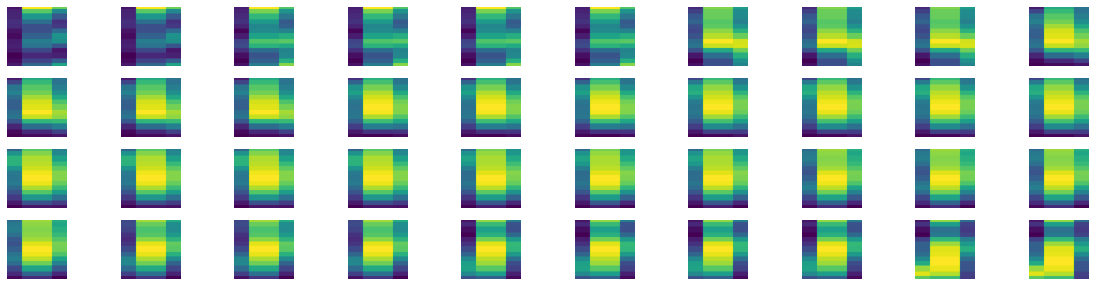

In [91]:
ind=np.random.choice(np.shape(X)[0])
ym=np.argmax(y, axis=1)
plt.figure(figsize=(20,5))

for i in range(40):
  plt.subplot(4,10,i+1)
  plt.imshow(X[ind,:,:,i])
  plt.axis('off')
print(ym[ind])

In [32]:
def get_model(width=40, height=40, depth=40):
    """Build a 3D convolutional neural network model."""

    inputs =Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=40, height=40, depth=40)
model.summary()

NameError: ignored

In [50]:
print(np.shape(X))
print(np.argmax(y, axis=1))

(10, 40, 40, 40)
[0 1 0 1 0 1 1 1 1 1]
